In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Chinese Liquor stocks

### Sichuan Swellfun Co.,Ltd. (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600779.SS_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-24    14.078787  14.004494 -39.930588 -2698175.0     2.0
1  2000-01-25    14.727272  14.115691  -3.361342  2489423.0     2.0
2  2000-01-26    14.787878  14.219104 -35.135148  7249607.0     2.0
3  2000-01-27    14.284848  14.229219 -57.567561  4991464.0     2.0
4  2000-01-28    14.412121  14.257357 -51.891890  7816168.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4517, 15, 4)

In [9]:
v = X.reshape(X.shape[0],15, 4)
v[0]

array([[0.03753306, 0.        , 0.43393405, 0.        ],
       [0.32439651, 0.10658729, 0.95234878, 0.22162281],
       [0.35120614, 0.20571404, 0.50191541, 0.42498578],
       [0.12868622, 0.21540926, 0.18390794, 0.32851416],
       [0.18498644, 0.24238165, 0.26436766, 0.44919021],
       [0.13404814, 0.2482232 , 0.19157077, 0.32855158],
       [0.4852547 , 0.37024746, 0.69348677, 0.56277963],
       [0.24396762, 0.3930611 , 0.34865879, 0.32765135],
       [0.39410154, 0.46241496, 0.56321805, 0.50635982],
       [0.        , 0.38971771, 0.        , 0.29498769],
       [0.10991948, 0.36484842, 0.15708803, 0.40989448],
       [0.34584421, 0.42245519, 0.49425258, 0.53976983],
       [1.        , 0.68927471, 1.        , 1.        ],
       [0.82037506, 0.85516367, 0.30411405, 0.63239659],
       [0.83377988, 1.        , 0.31488626, 0.77348774]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4517,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
29/29 [==============================] - 1s 32ms/step - loss: 0.2983 - accuracy: 0.5156 - mse: 0.4351 - weighted_accuracy: 0.2997 - weighted_mse: 0.5255 - val_loss: 0.3002 - val_accuracy: 0.0454 - val_mse: 0.3544 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3544
Epoch 2/200
29/29 [==============================] - 0s 8ms/step - loss: 0.2156 - accuracy: 0.3501 - mse: 0.7660 - weighted_accuracy: 0.4004 - weighted_mse: 0.7504 - val_loss: 0.2928 - val_accuracy: 0.0454 - val_mse: 0.3870 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3870
Epoch 3/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1932 - accuracy: 0.3197 - mse: 1.0054 - weighted_accuracy: 0.4709 - weighted_mse: 0.9778 - val_loss: 0.2838 - val_accuracy: 0.0454 - val_mse: 0.4283 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4283
Epoch 4/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1829 - accuracy: 0.3266 - mse: 1.1278 - weighted_accuracy: 0.5123 - weighte

Epoch 30/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1381 - accuracy: 0.3878 - mse: 1.6516 - weighted_accuracy: 0.7038 - weighted_mse: 1.5857 - val_loss: 0.1934 - val_accuracy: 0.3617 - val_mse: 1.6564 - val_weighted_accuracy: 0.3617 - val_weighted_mse: 1.6564
Epoch 31/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1375 - accuracy: 0.4168 - mse: 1.6613 - weighted_accuracy: 0.7144 - weighted_mse: 1.5948 - val_loss: 0.1926 - val_accuracy: 0.3496 - val_mse: 1.7052 - val_weighted_accuracy: 0.3496 - val_weighted_mse: 1.7052
Epoch 32/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1371 - accuracy: 0.4157 - mse: 1.6947 - weighted_accuracy: 0.7121 - weighted_mse: 1.6350 - val_loss: 0.1927 - val_accuracy: 0.3861 - val_mse: 1.7528 - val_weighted_accuracy: 0.3861 - val_weighted_mse: 1.7528
Epoch 33/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1361 - accuracy: 0.4135 - mse: 1.6916 - weighted_accuracy: 0.7249 - weig

Epoch 59/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1139 - accuracy: 0.5289 - mse: 2.0989 - weighted_accuracy: 0.7846 - weighted_mse: 2.0861 - val_loss: 0.1825 - val_accuracy: 0.4801 - val_mse: 2.2121 - val_weighted_accuracy: 0.4801 - val_weighted_mse: 2.2121
Epoch 60/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1135 - accuracy: 0.5812 - mse: 2.1267 - weighted_accuracy: 0.8019 - weighted_mse: 2.1453 - val_loss: 0.1862 - val_accuracy: 0.4779 - val_mse: 2.1787 - val_weighted_accuracy: 0.4779 - val_weighted_mse: 2.1787
Epoch 61/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1118 - accuracy: 0.5826 - mse: 2.1547 - weighted_accuracy: 0.8199 - weighted_mse: 2.1763 - val_loss: 0.1849 - val_accuracy: 0.4701 - val_mse: 2.1556 - val_weighted_accuracy: 0.4701 - val_weighted_mse: 2.1556
Epoch 62/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1120 - accuracy: 0.5497 - mse: 2.1729 - weighted_accuracy: 0.7981 - weig

Epoch 88/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0922 - accuracy: 0.6972 - mse: 2.7737 - weighted_accuracy: 0.8560 - weighted_mse: 2.8575 - val_loss: 0.1680 - val_accuracy: 0.6327 - val_mse: 3.0005 - val_weighted_accuracy: 0.6327 - val_weighted_mse: 3.0005
Epoch 89/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0916 - accuracy: 0.6609 - mse: 2.7993 - weighted_accuracy: 0.8563 - weighted_mse: 2.8312 - val_loss: 0.1774 - val_accuracy: 0.5918 - val_mse: 3.1642 - val_weighted_accuracy: 0.5918 - val_weighted_mse: 3.1642
Epoch 90/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0905 - accuracy: 0.7036 - mse: 2.8522 - weighted_accuracy: 0.8681 - weighted_mse: 2.9376 - val_loss: 0.1832 - val_accuracy: 0.5719 - val_mse: 2.9804 - val_weighted_accuracy: 0.5719 - val_weighted_mse: 2.9804
Epoch 91/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0896 - accuracy: 0.6751 - mse: 2.8646 - weighted_accuracy: 0.8693 - weig

Epoch 117/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0708 - accuracy: 0.7750 - mse: 3.8057 - weighted_accuracy: 0.9117 - weighted_mse: 3.8374 - val_loss: 0.1843 - val_accuracy: 0.6726 - val_mse: 4.1226 - val_weighted_accuracy: 0.6726 - val_weighted_mse: 4.1226
Epoch 118/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0718 - accuracy: 0.7703 - mse: 3.8384 - weighted_accuracy: 0.9003 - weighted_mse: 3.8643 - val_loss: 0.1857 - val_accuracy: 0.6471 - val_mse: 4.1012 - val_weighted_accuracy: 0.6471 - val_weighted_mse: 4.1012
Epoch 119/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0696 - accuracy: 0.7592 - mse: 3.8472 - weighted_accuracy: 0.9040 - weighted_mse: 3.8777 - val_loss: 0.1919 - val_accuracy: 0.6316 - val_mse: 3.8141 - val_weighted_accuracy: 0.6316 - val_weighted_mse: 3.8141
Epoch 120/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0697 - accuracy: 0.7908 - mse: 3.9194 - weighted_accuracy: 0.9136 - 

Epoch 146/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0596 - accuracy: 0.8115 - mse: 4.9718 - weighted_accuracy: 0.9232 - weighted_mse: 4.8898 - val_loss: 0.2100 - val_accuracy: 0.6748 - val_mse: 5.3013 - val_weighted_accuracy: 0.6748 - val_weighted_mse: 5.3013
Epoch 147/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0566 - accuracy: 0.8353 - mse: 5.0451 - weighted_accuracy: 0.9299 - weighted_mse: 5.0124 - val_loss: 0.2024 - val_accuracy: 0.6858 - val_mse: 5.3803 - val_weighted_accuracy: 0.6858 - val_weighted_mse: 5.3803
Epoch 148/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0580 - accuracy: 0.8242 - mse: 5.0430 - weighted_accuracy: 0.9278 - weighted_mse: 4.9958 - val_loss: 0.1975 - val_accuracy: 0.7080 - val_mse: 5.4942 - val_weighted_accuracy: 0.7080 - val_weighted_mse: 5.4942
Epoch 149/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.8397 - mse: 5.1332 - weighted_accuracy: 0.9355 - 

Epoch 175/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0452 - accuracy: 0.8688 - mse: 6.3398 - weighted_accuracy: 0.9442 - weighted_mse: 6.1634 - val_loss: 0.2153 - val_accuracy: 0.7223 - val_mse: 6.8219 - val_weighted_accuracy: 0.7223 - val_weighted_mse: 6.8219
Epoch 176/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0437 - accuracy: 0.8785 - mse: 6.4682 - weighted_accuracy: 0.9497 - weighted_mse: 6.2967 - val_loss: 0.2170 - val_accuracy: 0.7124 - val_mse: 6.4531 - val_weighted_accuracy: 0.7124 - val_weighted_mse: 6.4531
Epoch 177/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.8849 - mse: 6.5999 - weighted_accuracy: 0.9539 - weighted_mse: 6.3700 - val_loss: 0.2250 - val_accuracy: 0.7002 - val_mse: 6.8294 - val_weighted_accuracy: 0.7002 - val_weighted_mse: 6.8294
Epoch 178/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0442 - accuracy: 0.8655 - mse: 6.5596 - weighted_accuracy: 0.9429 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23533523082733154
Test accuracy: 0.7356194853782654


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[ 0.24461256 -3.9720402  -0.7378529 ]
 [-4.160408   -1.8444333   1.3645958 ]
 [-4.7322726  -2.190667    1.6426771 ]
 ...
 [-0.9625708  -4.2080464   0.41170627]
 [-2.5962074  -3.6465464   2.2596006 ]
 [-2.5554988  -2.7897096   2.166383  ]]


Counter({0: 82, 2: 739, 1: 83})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 822, 1: 41, 0: 41})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 904
actual predicted buys: 0
actual buys but predicted sell: 2
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 38
actual holds but predicted buy: 83
actual holds but predicted sell: 77
actual predicted holds: 662
Percentage buys correct: 0.0%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 80.5352798053528%
actual buys: 41
actual sells: 41
actual holds: 822


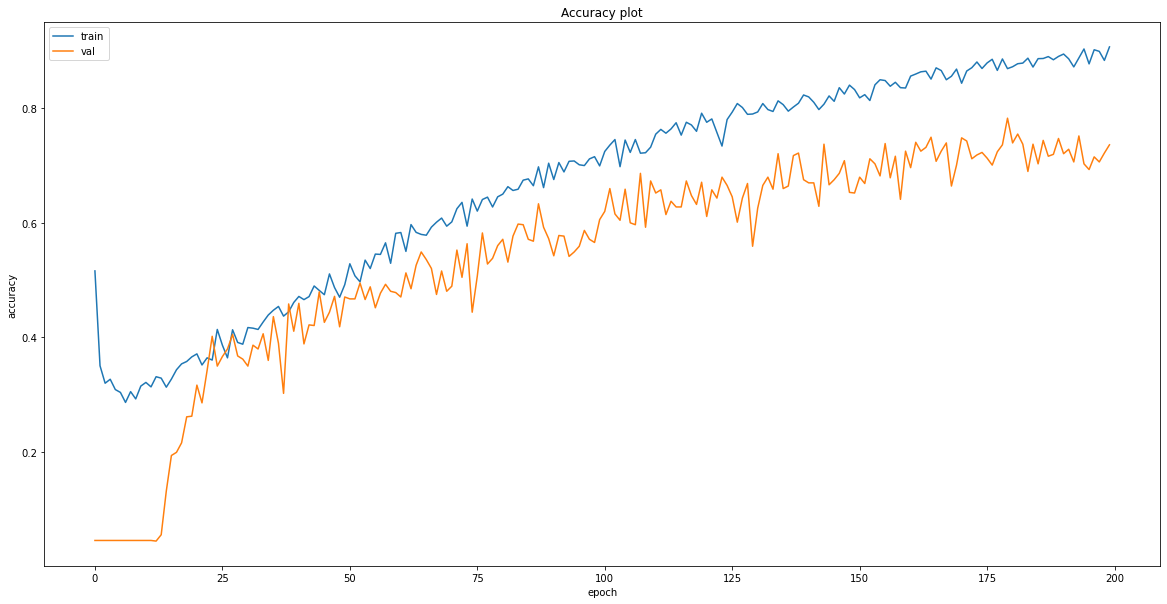

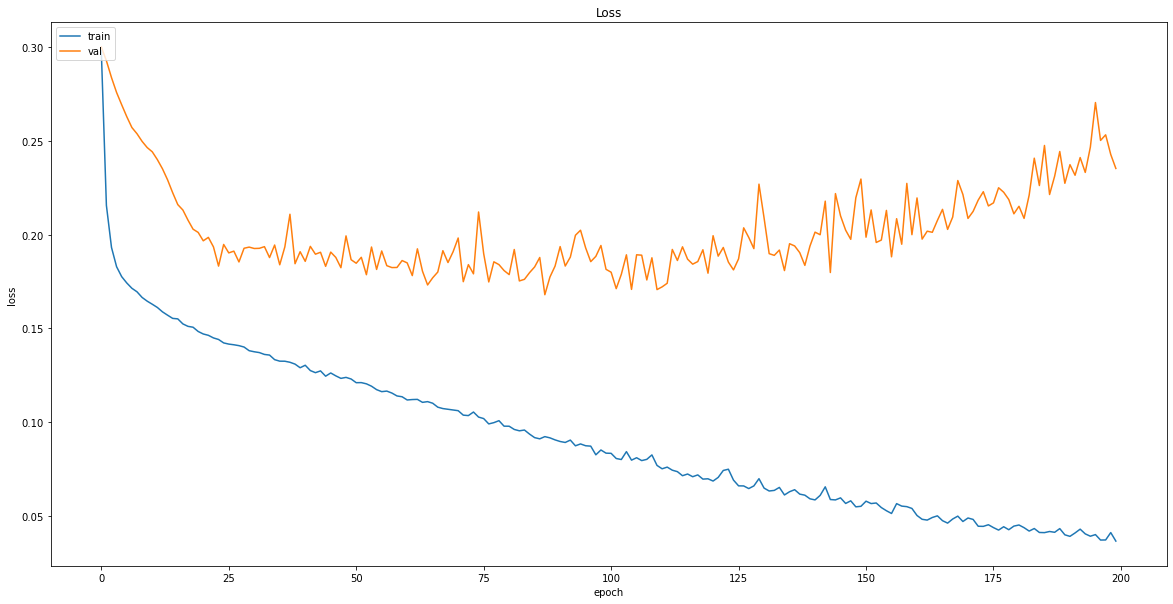

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('600779.SS_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/600779.SS_time_series_lstm_buy_hold_sell.model\assets


## Wuliangye Yibin Co.,Ltd. (Mid Cap)

In [23]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/000858.SZ_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
1  2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2  2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
3  2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
4  2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


In [24]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-24,4.396951,4.259450,-20.237909,91957609.0,2.0
2000-01-25,4.523540,4.300079,-16.033642,115224048.0,2.0
2000-01-26,4.400991,4.315604,-35.231971,105394663.0,2.0
2000-01-27,4.399644,4.328533,-51.735021,77180955.0,2.0
2000-01-28,4.302682,4.324556,-63.091500,43145413.0,2.0


In [25]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [26]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4498, 15, 4)

In [27]:
y = labels
y = np.array(y)

In [28]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [29]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [30]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [32]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
29/29 [==============================] - 1s 30ms/step - loss: 0.3035 - accuracy: 0.5422 - mse: 0.4218 - weighted_accuracy: 0.3030 - weighted_mse: 0.5316 - val_loss: 0.2998 - val_accuracy: 0.0422 - val_mse: 0.3536 - val_weighted_accuracy: 0.0422 - val_weighted_mse: 0.3536
Epoch 2/200
29/29 [==============================] - 0s 7ms/step - loss: 0.2170 - accuracy: 0.4227 - mse: 0.7123 - weighted_accuracy: 0.4231 - weighted_mse: 0.7213 - val_loss: 0.2917 - val_accuracy: 0.0444 - val_mse: 0.3842 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3842
Epoch 3/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.3146 - mse: 0.9691 - weighted_accuracy: 0.4617 - weighted_mse: 0.9466 - val_loss: 0.2816 - val_accuracy: 0.0444 - val_mse: 0.4241 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.4241
Epoch 4/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1851 - accuracy: 0.3066 - mse: 1.1323 - weighted_accuracy: 0.4753 - weighte

Epoch 30/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1379 - accuracy: 0.3788 - mse: 1.6445 - weighted_accuracy: 0.7049 - weighted_mse: 1.5487 - val_loss: 0.1896 - val_accuracy: 0.3522 - val_mse: 1.6554 - val_weighted_accuracy: 0.3522 - val_weighted_mse: 1.6554
Epoch 31/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1358 - accuracy: 0.3944 - mse: 1.6497 - weighted_accuracy: 0.7187 - weighted_mse: 1.5641 - val_loss: 0.1864 - val_accuracy: 0.3778 - val_mse: 1.6404 - val_weighted_accuracy: 0.3778 - val_weighted_mse: 1.6404
Epoch 32/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1358 - accuracy: 0.4011 - mse: 1.6526 - weighted_accuracy: 0.7071 - weighted_mse: 1.5803 - val_loss: 0.1858 - val_accuracy: 0.3933 - val_mse: 1.6252 - val_weighted_accuracy: 0.3933 - val_weighted_mse: 1.6252
Epoch 33/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1341 - accuracy: 0.4083 - mse: 1.6873 - weighted_accuracy: 0.7158 - weig

Epoch 59/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1160 - accuracy: 0.5264 - mse: 2.0859 - weighted_accuracy: 0.7949 - weighted_mse: 2.0536 - val_loss: 0.1917 - val_accuracy: 0.4367 - val_mse: 2.1784 - val_weighted_accuracy: 0.4367 - val_weighted_mse: 2.1784
Epoch 60/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1149 - accuracy: 0.5136 - mse: 2.1215 - weighted_accuracy: 0.7862 - weighted_mse: 2.1056 - val_loss: 0.1864 - val_accuracy: 0.4578 - val_mse: 2.1868 - val_weighted_accuracy: 0.4578 - val_weighted_mse: 2.1868
Epoch 61/200
29/29 [==============================] - 0s 7ms/step - loss: 0.1142 - accuracy: 0.5350 - mse: 2.1054 - weighted_accuracy: 0.7940 - weighted_mse: 2.0899 - val_loss: 0.1722 - val_accuracy: 0.5033 - val_mse: 2.0653 - val_weighted_accuracy: 0.5033 - val_weighted_mse: 2.0653
Epoch 62/200
29/29 [==============================] - 0s 6ms/step - loss: 0.1193 - accuracy: 0.5356 - mse: 2.0835 - weighted_accuracy: 0.7843 - weig

Epoch 88/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0995 - accuracy: 0.5989 - mse: 2.5106 - weighted_accuracy: 0.8354 - weighted_mse: 2.5504 - val_loss: 0.1746 - val_accuracy: 0.5433 - val_mse: 2.7209 - val_weighted_accuracy: 0.5433 - val_weighted_mse: 2.7209
Epoch 89/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0967 - accuracy: 0.6520 - mse: 2.5079 - weighted_accuracy: 0.8507 - weighted_mse: 2.5721 - val_loss: 0.1761 - val_accuracy: 0.5522 - val_mse: 2.6205 - val_weighted_accuracy: 0.5522 - val_weighted_mse: 2.6205
Epoch 90/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0957 - accuracy: 0.6656 - mse: 2.5275 - weighted_accuracy: 0.8559 - weighted_mse: 2.5890 - val_loss: 0.1818 - val_accuracy: 0.5467 - val_mse: 2.6904 - val_weighted_accuracy: 0.5467 - val_weighted_mse: 2.6904
Epoch 91/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0985 - accuracy: 0.6331 - mse: 2.5902 - weighted_accuracy: 0.8359 - weig

Epoch 117/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0874 - accuracy: 0.6901 - mse: 3.0992 - weighted_accuracy: 0.8727 - weighted_mse: 3.1577 - val_loss: 0.1585 - val_accuracy: 0.6500 - val_mse: 3.3933 - val_weighted_accuracy: 0.6500 - val_weighted_mse: 3.3933
Epoch 118/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0801 - accuracy: 0.7337 - mse: 3.1065 - weighted_accuracy: 0.9006 - weighted_mse: 3.1879 - val_loss: 0.1751 - val_accuracy: 0.6011 - val_mse: 3.3421 - val_weighted_accuracy: 0.6011 - val_weighted_mse: 3.3421
Epoch 119/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0792 - accuracy: 0.7215 - mse: 3.1894 - weighted_accuracy: 0.8882 - weighted_mse: 3.2845 - val_loss: 0.1672 - val_accuracy: 0.6322 - val_mse: 3.4000 - val_weighted_accuracy: 0.6322 - val_weighted_mse: 3.4000
Epoch 120/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0790 - accuracy: 0.7424 - mse: 3.2532 - weighted_accuracy: 0.8897 - 

Epoch 146/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0774 - accuracy: 0.7126 - mse: 3.8356 - weighted_accuracy: 0.8809 - weighted_mse: 3.9585 - val_loss: 0.1500 - val_accuracy: 0.6911 - val_mse: 3.8559 - val_weighted_accuracy: 0.6911 - val_weighted_mse: 3.8559
Epoch 147/200
29/29 [==============================] - 0s 7ms/step - loss: 0.0709 - accuracy: 0.7693 - mse: 3.7782 - weighted_accuracy: 0.9097 - weighted_mse: 3.8791 - val_loss: 0.1804 - val_accuracy: 0.6256 - val_mse: 3.7862 - val_weighted_accuracy: 0.6256 - val_weighted_mse: 3.7862
Epoch 148/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0690 - accuracy: 0.7721 - mse: 3.8201 - weighted_accuracy: 0.9107 - weighted_mse: 3.9236 - val_loss: 0.1861 - val_accuracy: 0.6111 - val_mse: 3.9519 - val_weighted_accuracy: 0.6111 - val_weighted_mse: 3.9519
Epoch 149/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0706 - accuracy: 0.7574 - mse: 3.9095 - weighted_accuracy: 0.8993 - 

29/29 [==============================] - 0s 6ms/step - loss: 0.0590 - accuracy: 0.8127 - mse: 4.4100 - weighted_accuracy: 0.9255 - weighted_mse: 4.5573 - val_loss: 0.1679 - val_accuracy: 0.6833 - val_mse: 4.8987 - val_weighted_accuracy: 0.6833 - val_weighted_mse: 4.8987
Epoch 175/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0589 - accuracy: 0.8168 - mse: 4.4508 - weighted_accuracy: 0.9250 - weighted_mse: 4.6229 - val_loss: 0.1795 - val_accuracy: 0.6533 - val_mse: 4.8343 - val_weighted_accuracy: 0.6533 - val_weighted_mse: 4.8343
Epoch 176/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0764 - accuracy: 0.7604 - mse: 4.5173 - weighted_accuracy: 0.8944 - weighted_mse: 4.5817 - val_loss: 0.2371 - val_accuracy: 0.5778 - val_mse: 5.4729 - val_weighted_accuracy: 0.5778 - val_weighted_mse: 5.4729
Epoch 177/200
29/29 [==============================] - 0s 6ms/step - loss: 0.0729 - accuracy: 0.7454 - mse: 4.4023 - weighted_accuracy: 0.9030 - weighted_mse: 

In [33]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14777177572250366
Test accuracy: 0.7566666603088379


In [34]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-5.2028384  -2.6760962   2.3887656 ]
 [-3.3450694  -0.76511395 -0.53572595]
 [-3.4905572  -0.9941835   0.55052304]
 ...
 [-2.1193233  -3.4365678   1.4467269 ]
 [-3.2938762  -2.3346646   1.9318568 ]
 [-1.1426934  -2.2392309   0.11568265]]


Counter({2: 741, 1: 78, 0: 81})

In [35]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 821, 0: 39, 1: 40})

In [36]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 900
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 35
actual sells but predicted buy: 1
actual predicted sells: 4
actual sells but predicted hold: 34
actual holds but predicted buy: 72
actual holds but predicted sell: 77
actual predicted holds: 672
Percentage buys correct: 12.5%
Percentage sells correct: 10.256410256410257%
Percentage holds correct: 81.85140073081608%
actual buys: 40
actual sells: 39
actual holds: 821


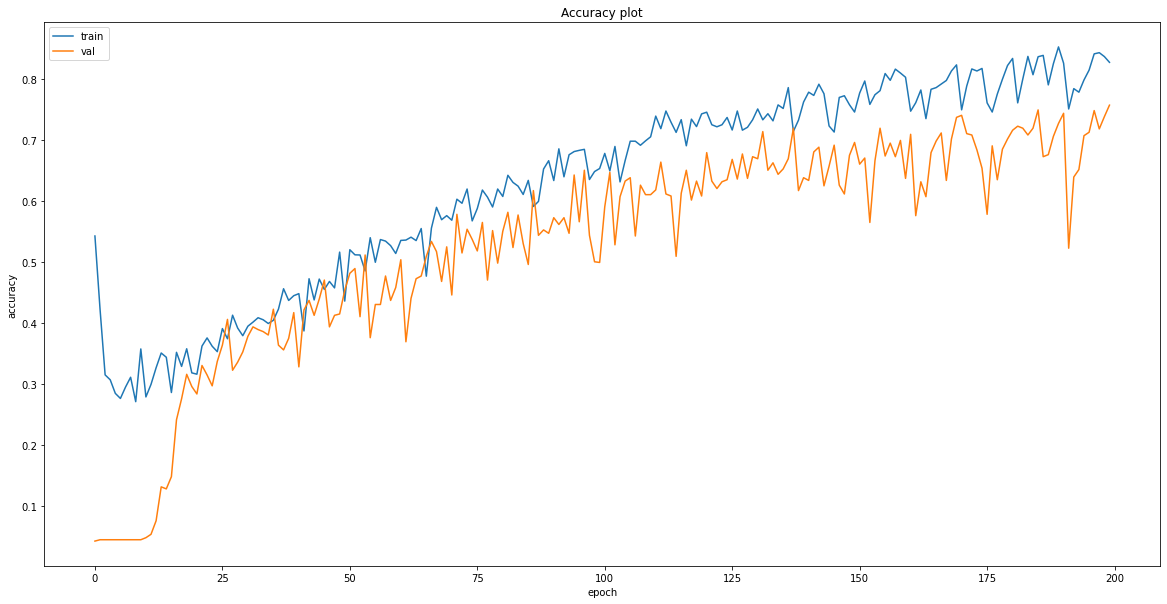

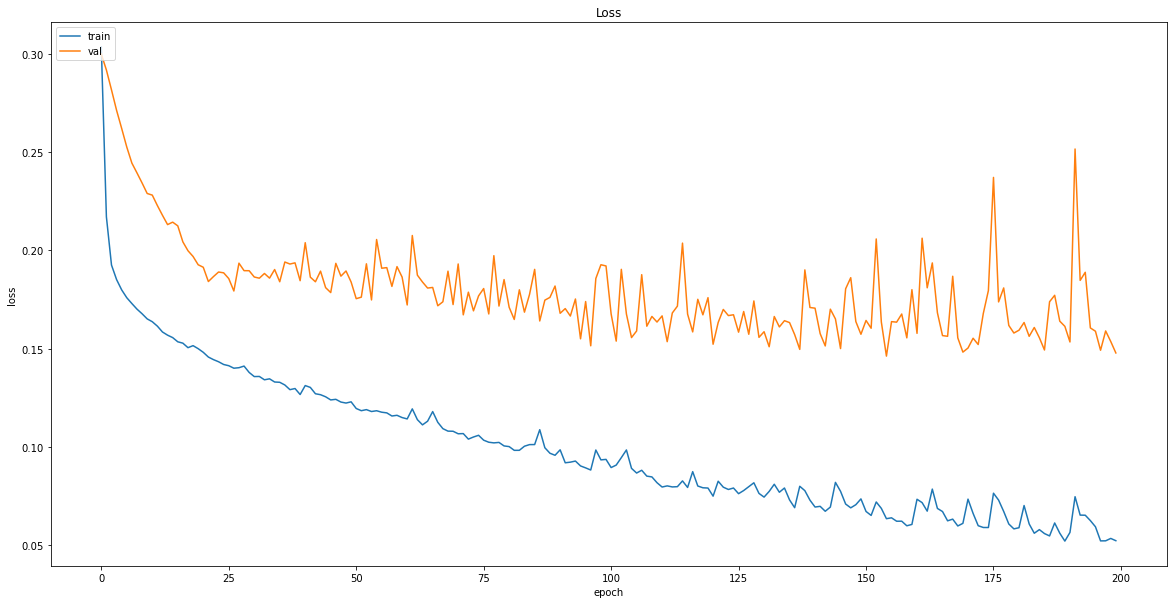

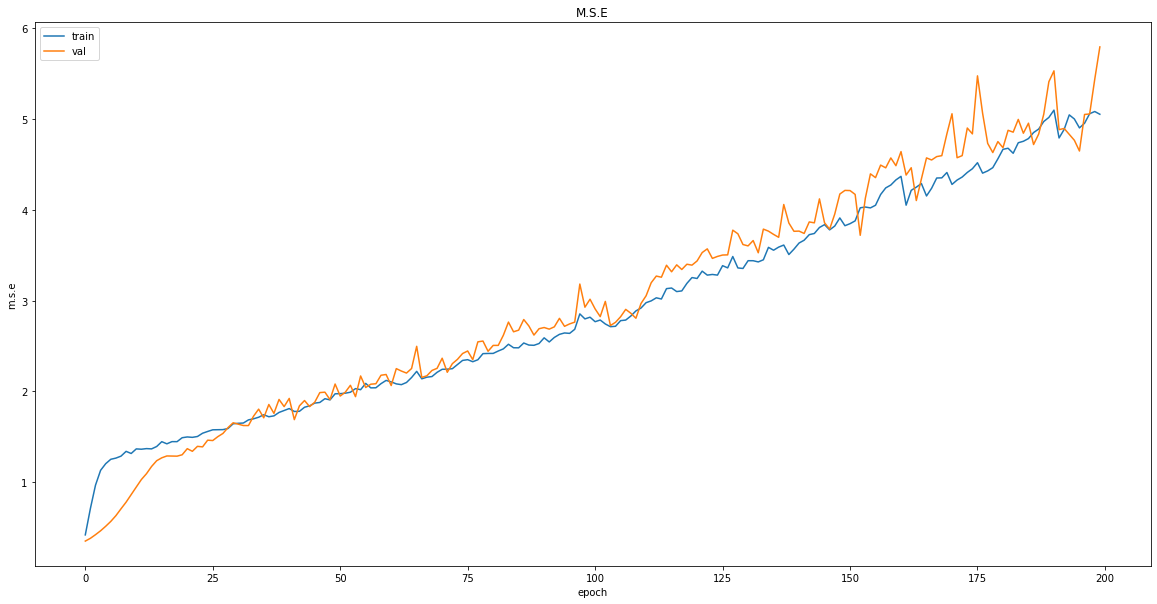

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
# Save model
model.save("models/{}".format('000858.SZ_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/000858.SZ_time_series_lstm_buy_hold_sell.model\assets


## Kweichow Moutai Co., Ltd (Large Cap)

In [39]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


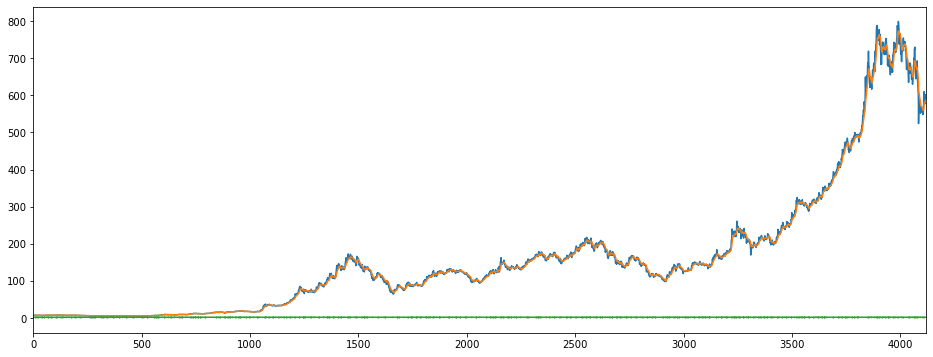

In [40]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [41]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [42]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [43]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4106, 15, 4)

In [44]:
y = labels
y = np.array(y)

In [45]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [46]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [47]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [49]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
26/26 [==============================] - 1s 34ms/step - loss: 0.3042 - accuracy: 0.5250 - mse: 0.4305 - weighted_accuracy: 0.3198 - weighted_mse: 0.5168 - val_loss: 0.3008 - val_accuracy: 0.0426 - val_mse: 0.3515 - val_weighted_accuracy: 0.0426 - val_weighted_mse: 0.3515
Epoch 2/200
26/26 [==============================] - 0s 8ms/step - loss: 0.2189 - accuracy: 0.4190 - mse: 0.6850 - weighted_accuracy: 0.4296 - weighted_mse: 0.6941 - val_loss: 0.2939 - val_accuracy: 0.0450 - val_mse: 0.3760 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.3760
Epoch 3/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1929 - accuracy: 0.3161 - mse: 0.9368 - weighted_accuracy: 0.4802 - weighted_mse: 0.9091 - val_loss: 0.2845 - val_accuracy: 0.0450 - val_mse: 0.4108 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.4108
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1821 - accuracy: 0.2850 - mse: 1.1040 - weighted_accuracy: 0.5250 - weighte

Epoch 30/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1328 - accuracy: 0.4147 - mse: 1.7297 - weighted_accuracy: 0.7212 - weighted_mse: 1.6344 - val_loss: 0.1846 - val_accuracy: 0.3966 - val_mse: 1.7192 - val_weighted_accuracy: 0.3966 - val_weighted_mse: 1.7192
Epoch 31/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1321 - accuracy: 0.4290 - mse: 1.7456 - weighted_accuracy: 0.7351 - weighted_mse: 1.6626 - val_loss: 0.1998 - val_accuracy: 0.3309 - val_mse: 1.7067 - val_weighted_accuracy: 0.3309 - val_weighted_mse: 1.7067
Epoch 32/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1313 - accuracy: 0.4263 - mse: 1.7693 - weighted_accuracy: 0.7126 - weighted_mse: 1.6854 - val_loss: 0.1740 - val_accuracy: 0.4830 - val_mse: 1.7277 - val_weighted_accuracy: 0.4830 - val_weighted_mse: 1.7277
Epoch 33/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.4568 - mse: 1.7754 - weighted_accuracy: 0.7431 - weig

Epoch 59/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1033 - accuracy: 0.6178 - mse: 2.2767 - weighted_accuracy: 0.8236 - weighted_mse: 2.2841 - val_loss: 0.1853 - val_accuracy: 0.4915 - val_mse: 2.3585 - val_weighted_accuracy: 0.4915 - val_weighted_mse: 2.3585
Epoch 60/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1036 - accuracy: 0.6319 - mse: 2.3099 - weighted_accuracy: 0.8308 - weighted_mse: 2.3057 - val_loss: 0.1918 - val_accuracy: 0.4708 - val_mse: 2.4615 - val_weighted_accuracy: 0.4708 - val_weighted_mse: 2.4615
Epoch 61/200
26/26 [==============================] - 0s 7ms/step - loss: 0.1023 - accuracy: 0.6166 - mse: 2.3435 - weighted_accuracy: 0.8274 - weighted_mse: 2.3503 - val_loss: 0.1494 - val_accuracy: 0.6545 - val_mse: 2.3454 - val_weighted_accuracy: 0.6545 - val_weighted_mse: 2.3454
Epoch 62/200
26/26 [==============================] - 0s 6ms/step - loss: 0.1037 - accuracy: 0.6057 - mse: 2.3971 - weighted_accuracy: 0.8298 - weig

Epoch 88/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0798 - accuracy: 0.7463 - mse: 3.2501 - weighted_accuracy: 0.8943 - weighted_mse: 3.2942 - val_loss: 0.2052 - val_accuracy: 0.5365 - val_mse: 3.2388 - val_weighted_accuracy: 0.5365 - val_weighted_mse: 3.2388
Epoch 89/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0777 - accuracy: 0.7473 - mse: 3.2318 - weighted_accuracy: 0.8989 - weighted_mse: 3.2986 - val_loss: 0.1770 - val_accuracy: 0.5949 - val_mse: 3.3621 - val_weighted_accuracy: 0.5949 - val_weighted_mse: 3.3621
Epoch 90/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0775 - accuracy: 0.7479 - mse: 3.3585 - weighted_accuracy: 0.8991 - weighted_mse: 3.4019 - val_loss: 0.1580 - val_accuracy: 0.6569 - val_mse: 3.3190 - val_weighted_accuracy: 0.6569 - val_weighted_mse: 3.3190
Epoch 91/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0772 - accuracy: 0.7585 - mse: 3.3187 - weighted_accuracy: 0.9073 - weig

Epoch 117/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.8298 - mse: 4.6687 - weighted_accuracy: 0.9312 - weighted_mse: 4.6872 - val_loss: 0.1883 - val_accuracy: 0.6229 - val_mse: 4.6276 - val_weighted_accuracy: 0.6229 - val_weighted_mse: 4.6276
Epoch 118/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0565 - accuracy: 0.8307 - mse: 4.7751 - weighted_accuracy: 0.9358 - weighted_mse: 4.7290 - val_loss: 0.1620 - val_accuracy: 0.7105 - val_mse: 4.9957 - val_weighted_accuracy: 0.7105 - val_weighted_mse: 4.9957
Epoch 119/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0577 - accuracy: 0.8243 - mse: 4.6947 - weighted_accuracy: 0.9271 - weighted_mse: 4.6611 - val_loss: 0.2017 - val_accuracy: 0.6131 - val_mse: 4.7014 - val_weighted_accuracy: 0.6131 - val_weighted_mse: 4.7014
Epoch 120/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0579 - accuracy: 0.8261 - mse: 4.7919 - weighted_accuracy: 0.9321 - 

Epoch 146/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0427 - accuracy: 0.8831 - mse: 6.3948 - weighted_accuracy: 0.9529 - weighted_mse: 6.1495 - val_loss: 0.1795 - val_accuracy: 0.7409 - val_mse: 7.0885 - val_weighted_accuracy: 0.7409 - val_weighted_mse: 7.0885
Epoch 147/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0408 - accuracy: 0.8739 - mse: 6.5234 - weighted_accuracy: 0.9538 - weighted_mse: 6.3481 - val_loss: 0.1634 - val_accuracy: 0.7689 - val_mse: 7.2249 - val_weighted_accuracy: 0.7689 - val_weighted_mse: 7.2249
Epoch 148/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.8934 - mse: 6.6112 - weighted_accuracy: 0.9588 - weighted_mse: 6.2830 - val_loss: 0.1973 - val_accuracy: 0.7153 - val_mse: 7.0804 - val_weighted_accuracy: 0.7153 - val_weighted_mse: 7.0804
Epoch 149/200
26/26 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.8837 - mse: 6.6174 - weighted_accuracy: 0.9574 - 

Epoch 175/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9175 - mse: 8.7588 - weighted_accuracy: 0.9655 - weighted_mse: 8.1246 - val_loss: 0.2095 - val_accuracy: 0.7287 - val_mse: 8.4835 - val_weighted_accuracy: 0.7287 - val_weighted_mse: 8.4835
Epoch 176/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9120 - mse: 8.7605 - weighted_accuracy: 0.9678 - weighted_mse: 8.0959 - val_loss: 0.2060 - val_accuracy: 0.7664 - val_mse: 9.7998 - val_weighted_accuracy: 0.7664 - val_weighted_mse: 9.7998
Epoch 177/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9199 - mse: 8.9053 - weighted_accuracy: 0.9707 - weighted_mse: 8.2235 - val_loss: 0.2337 - val_accuracy: 0.7056 - val_mse: 8.8203 - val_weighted_accuracy: 0.7056 - val_weighted_mse: 8.8203
Epoch 178/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9242 - mse: 8.9765 - weighted_accuracy: 0.9701 - 

In [50]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22932405769824982
Test accuracy: 0.7639902830123901


In [51]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.59692985 -5.6381392   0.22783127]
 [-2.3776956  -1.2449132  -0.18177807]
 [-2.9275336  -1.8952814   1.4751114 ]
 ...
 [-5.0578156  -6.069309    4.328623  ]
 [-0.7541364  -3.8582022   0.0133831 ]
 [-3.0983026  -2.070732    1.0335435 ]]


Counter({2: 684, 1: 58, 0: 80})

In [52]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [53]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 34
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 30
actual holds but predicted buy: 53
actual holds but predicted sell: 75
actual predicted holds: 620
Percentage buys correct: 8.108108108108109%
Percentage sells correct: 13.513513513513514%
Percentage holds correct: 82.88770053475936%
actual buys: 37
actual sells: 37
actual holds: 748


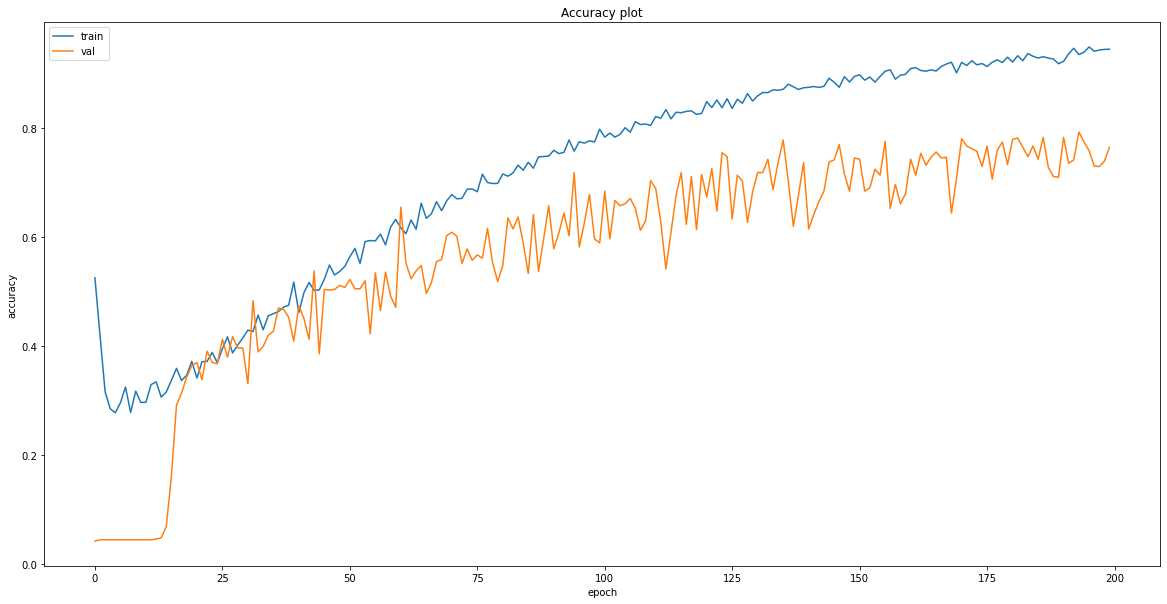

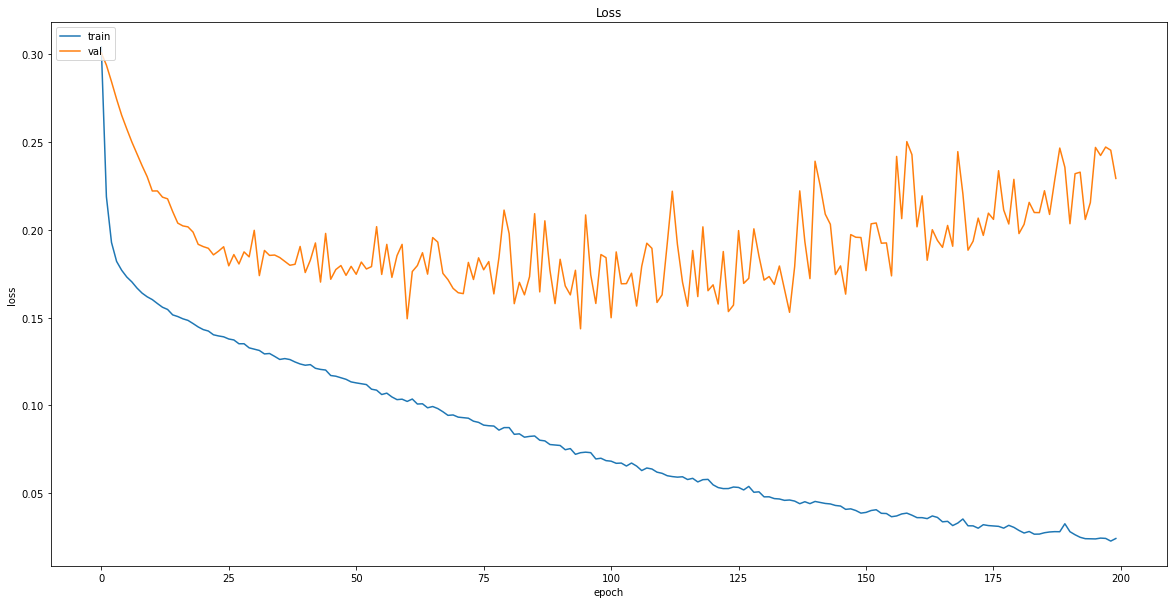

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
# Save model
model.save("models/{}".format('600519.SS_time_series_lstm_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/600519.SS_time_series_lstm_buy_hold_sell.model\assets
